In [13]:

%load_ext autoreload
%autoreload 2
%pip install hmmlearn
import pandas as pd
import folium 
import geopandas as gpd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
import paths_cpt 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, RocCurveDisplay, silhouette_score
import os
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from seglearn.transform import FeatureRep, SegmentX
from seglearn.pipe import Pype
from seglearn.datasets import load_watch
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import random

print(os.getcwd())
seed = 22

df = pd.read_parquet(paths_cpt.PATH_TO_PARQUET)
print(df.shape)
df.dropna(inplace=True)
df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: you may need to restart the kernel to use updated packages.
c:\Users\volte\OneDrive\Dokumente\usecase_cpt\CPT_usecase\modeling



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


(1222711, 19)


,sondering_id,index,pkey_sondering,sondeernummer,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,qc,fs,qtn,rf,fr,icn,sbt,ksbt,lithostrat_id
0,314,2593,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.6,13.66,1.17,0.035,35.894004,2.991453,3.058371,2.564340,5.0,1.434000e-07,Quartair
1,314,2594,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.7,13.56,1.57,0.033,42.562319,2.101911,2.138968,2.406724,5.0,4.321000e-07,Quartair
2,314,2595,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.8,13.46,1.43,0.036,38.536991,2.517483,2.569226,2.491219,5.0,2.392000e-07,Quartair
3,314,2596,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.9,13.36,0.50,0.024,15.678501,4.800000,5.111166,2.982185,3.0,7.700000e-09,Quartair
4,314,2597,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.0,13.26,1.33,0.023,33.203119,1.729323,1.772110,2.440158,5.0,3.419000e-07,Quartair


In [14]:
vec_lengths = []
for id in df.sondering_id.unique():
    vec_lengths.append(df[df["sondering_id"] == id].shape[0])
print(sum(vec_lengths) / len(vec_lengths))

760.0790697674419


In [15]:
# adjusted for usecase 

segments_oi = [
"Quartair",
"Diest",
"Bolderberg",
"Sint_Huibrechts_Hern",
"Ursel",
"Asse",
"Wemmel",
"Lede",
"Brussel",
"Merelbeke",
"Kwatrecht",
"Mont_Panisel",
"Aalbeke",
"Mons_en_Pevele",
]




In [16]:
# doing an encoding for things that need numeric outcomes, read that for HMM this would be teh way to encode the states 
# (one coliumn with numeric values, does not imply that they are ordered, might be wrong though)
mapping = {i:j for i,j in zip(segments_oi, range(0, len(segments_oi))) if i in segments_oi}
mapping

{'Quartair': 0,
 'Diest': 1,
 'Bolderberg': 2,
 'Sint_Huibrechts_Hern': 3,
 'Ursel': 4,
 'Asse': 5,
 'Wemmel': 6,
 'Lede': 7,
 'Brussel': 8,
 'Merelbeke': 9,
 'Kwatrecht': 10,
 'Mont_Panisel': 11,
 'Aalbeke': 12,
 'Mons_en_Pevele': 13}

In [17]:
# here we drop the segments that we are ot interested in
df["lithostrat_int"] = df.lithostrat_id.map(mapping)
df.dropna(inplace=True)

In [18]:
#target set with unknowns, other set without unknowns
target_set = df[(df["lithostrat_id"].isna()) | (df["lithostrat_id"]=="None") | df["lithostrat_id"].str.contains('Onbekend')]
train_set = df[~((df["lithostrat_id"].isna()) | (df["lithostrat_id"]=="None") | df["lithostrat_id"].str.contains('Onbekend'))]
print("rows in train and target are : ", train_set.shape[0], " ; ", target_set.shape[0], ",",\
       target_set.shape[0] + train_set.shape[0], " = ", df.shape[0])

rows in train and target are :  142407  ;  0 , 142407  =  142407


In [19]:
#train_set = train_set[['diepte',
 #      'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt', 'lithostrat_int']]
drillings = df.sondering_id.unique()
print(len(drillings) * (3/4))

drillings = drillings[0:159]

train = train_set[train_set.sondering_id.isin(drillings)]
test = train_set[~train_set.sondering_id.isin(drillings)]
test.head()


154.5


,sondering_id,index,pkey_sondering,sondeernummer,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,qc,fs,qtn,rf,fr,icn,sbt,ksbt,lithostrat_id,lithostrat_int
293962,4659,363548,https://www.dov.vlaanderen.be/data/sondering/2...,2017-11170-S8A-003,155860.83,172587.85,38.7,10.32,0.02,38.68,0.709,0.001,7.091463,0.141044,0.141095,2.645200,4.0,8.140000e-08,Quartair,0.0
293963,4659,363549,https://www.dov.vlaanderen.be/data/sondering/2...,2017-11170-S8A-003,155860.83,172587.85,38.7,10.32,0.04,38.66,1.033,0.003,146.338435,0.290416,0.290569,1.472725,6.0,2.984805e-04,Quartair,0.0
293964,4659,363550,https://www.dov.vlaanderen.be/data/sondering/2...,2017-11170-S8A-003,155860.83,172587.85,38.7,10.32,0.06,38.64,1.214,0.006,165.811088,0.494234,0.494579,1.548965,6.0,1.750437e-04,Quartair,0.0
293965,4659,363551,https://www.dov.vlaanderen.be/data/sondering/2...,2017-11170-S8A-003,155860.83,172587.85,38.7,10.32,0.08,38.62,1.386,0.011,193.338230,0.793651,0.794318,1.629568,6.0,9.956650e-05,Quartair,0.0
293966,4659,363552,https://www.dov.vlaanderen.be/data/sondering/2...,2017-11170-S8A-003,155860.83,172587.85,38.7,10.32,0.10,38.60,1.483,0.018,218.042895,1.213756,1.214980,1.726875,6.0,5.038490e-05,Quartair,0.0


In [20]:

def preproc_segs_to_dummies(df:pd.DataFrame)->pd.DataFrame:
    segments = df.lithostrat_id.unique()
    dict_segments = {seg : [] for seg in segments}
    dict_segments["x"] = []
    dict_segments["y"] = []
    drillings = df.sondering_id.unique()

    for drill in drillings:
        subdf = df[df["sondering_id"]==drill]
        dict_segments["x"].append(subdf.x.unique()[0])
        dict_segments["y"].append(subdf.y.unique()[0])
        for seg in segments:
            if seg in subdf.lithostrat_id.unique():
                dict_segments[seg].append(1)
            else:
                dict_segments[seg].append(0)

    df_segment_presence = pd.DataFrame(dict_segments)
    df_segment_presence["drilling"] = drillings

    return df_segment_presence

def plot_dummy_segpres(df_segment_presence:pd.DataFrame, filename="temp.html")->None:
    def pointlable(row):
        outp = []

        for seg in segments_oi:
            try:
                if row[seg]==1:
                    outp.append(seg)
            except:
                pass
        return ",".join(outp)

    df_segment_presence["label"] = df_segment_presence.apply(pointlable, axis=1)
    df_seg_filtered = df_segment_presence[df_segment_presence["label"].str.len()> 0]
    #print(df_segment_presence["label"])

    gdf = gpd.GeoDataFrame(
        df_seg_filtered,
        geometry=gpd.points_from_xy(df_seg_filtered["x"], df_seg_filtered["y"]),
        crs="EPSG:31370"
    )

    gdf = gdf.to_crs("EPSG:4326")

    df_seg_filtered["lon"] = gdf.geometry.x
    df_seg_filtered["lat"] = gdf.geometry.y

    m = folium.Map(location=[50.8, 4.3], zoom_start=10)

    for _, row in df_seg_filtered.iterrows():
        jitterx = row["lat"] + np.random.uniform(-0.001, 0.001)
        jittery = row["lon"] + np.random.uniform(-0.001, 0.001)
        folium.CircleMarker(
            location=[jitterx, jittery],
            fill=True,
            radius = 3,
            popup=str(row["label"]),
        ).add_to(m)

    folium.LayerControl().add_to(m)
    
    m.save(filename)

plot_dummy_segpres(preproc_segs_to_dummies(train), filename = "temp_trainplot.html")

plot_dummy_segpres(preproc_segs_to_dummies(test), filename = "temp_testplot.html")

## Base model to beat (KNN with x and y)

In [21]:
features = ["x", "y", "diepte_mtaw"]

ss = StandardScaler()
model0 = KNeighborsClassifier()
pipe_zero = Pipeline([("scale",ss),
                     ("knn", model0)])

X_train, y_train = train[features], train["lithostrat_id"]
X_test, y_test = test[features], test["lithostrat_id"]



features = []
pipe_zero.fit(X_train, y_train)

,steps,"[('scale', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30


In [22]:
y_pred = pipe_zero.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Overall accuracy:", accuracy)

classes = y_test.unique()
matrix = confusion_matrix(y_test, y_pred, labels=classes)

#This is apparently how you get per calss accuracy: 
# https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
granular_acc  = matrix.diagonal()/matrix.sum(axis=1)

df_summary = pd.DataFrame({
    "class": classes,
    "accuracy": granular_acc
})

print("avg accuracy : ", df_summary.accuracy.mean())
print("Individual accuracies : ")
df_summary

Overall accuracy: 0.3895466583579997
avg accuracy :  0.277072333710924
Individual accuracies : 


,class,accuracy
0,Quartair,0.684418
1,Bolderberg,0.000000
2,Ursel,0.785933
3,Asse,0.325916
4,Wemmel,0.026411
5,Lede,0.000000
6,Brussel,0.670973
7,Mons_en_Pevele,0.000000
8,Sint_Huibrechts_Hern,0.000000


In [23]:
X_train, y_train = train[['diepte_mtaw',
       'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt']], train["lithostrat_int"]
X_test, y_test = test[['diepte_mtaw',
       'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt']], test["lithostrat_int"]

## HMM experimentation

In [24]:
# this one sucks
#train_set = [] 
train_lengths = []
test_lengths = []
states = segments_oi

# Split based on drillings
hmm_train_set = train_set[train_set.sondering_id.isin(drillings)]
hmm_test_set = train_set[~train_set.sondering_id.isin(drillings)]

hmm_X_train = []
hmm_X_test = []

# we have to do this iteration to build numpy arrays for the hmm. 
for id in hmm_train_set.sondering_id.unique():
    subdf = hmm_train_set[hmm_train_set["sondering_id"] == id].copy()
    substate = subdf["icn"].values
    if len(substate) < 700:
        sublength = len(substate)
        pad_length = 700 - sublength
        substate = np.pad(np.asarray(substate, dtype="float64"), (0, pad_length),
                          mode='constant', constant_values=0)
        hmm_X_train.append(substate)
        train_lengths.append(700)

# same for test
for id in hmm_test_set.sondering_id.unique():
    subdf = hmm_test_set[hmm_test_set["sondering_id"] == id].copy()
    substate = subdf["icn"].values
    if len(substate) < 700:
        sublength = len(substate)
        pad_length = 700 - sublength
        substate = np.pad(np.asarray(substate, dtype="float64"), (0, pad_length),
                          mode='constant', constant_values=0)
        hmm_X_test.append(substate)
        test_lengths.append(700)

#we need to do some reshapings for the format to be right 
hmm_X_train = np.asarray(hmm_X_train, dtype="object")
hmm_X_train = np.concatenate(hmm_X_train).reshape(-1, 1)
hmm_X_test = np.asarray(hmm_X_test, dtype="object")
hmm_X_test = np.concatenate(hmm_X_test).reshape(-1, 1)

#we finally fit the model
hmm_model = hmm.GaussianHMM(n_components=3).fit(hmm_X_train, train_lengths)
test_score = hmm_model.score(hmm_X_test, test_lengths)
print("Test log-likelihood:", test_score)

Test log-likelihood: 31277.100744266623


In [25]:
log_likelihood = hmm_model.score(hmm_X_test, test_lengths)
print("Log-likelihood:", log_likelihood)

Log-likelihood: 31277.100744266623


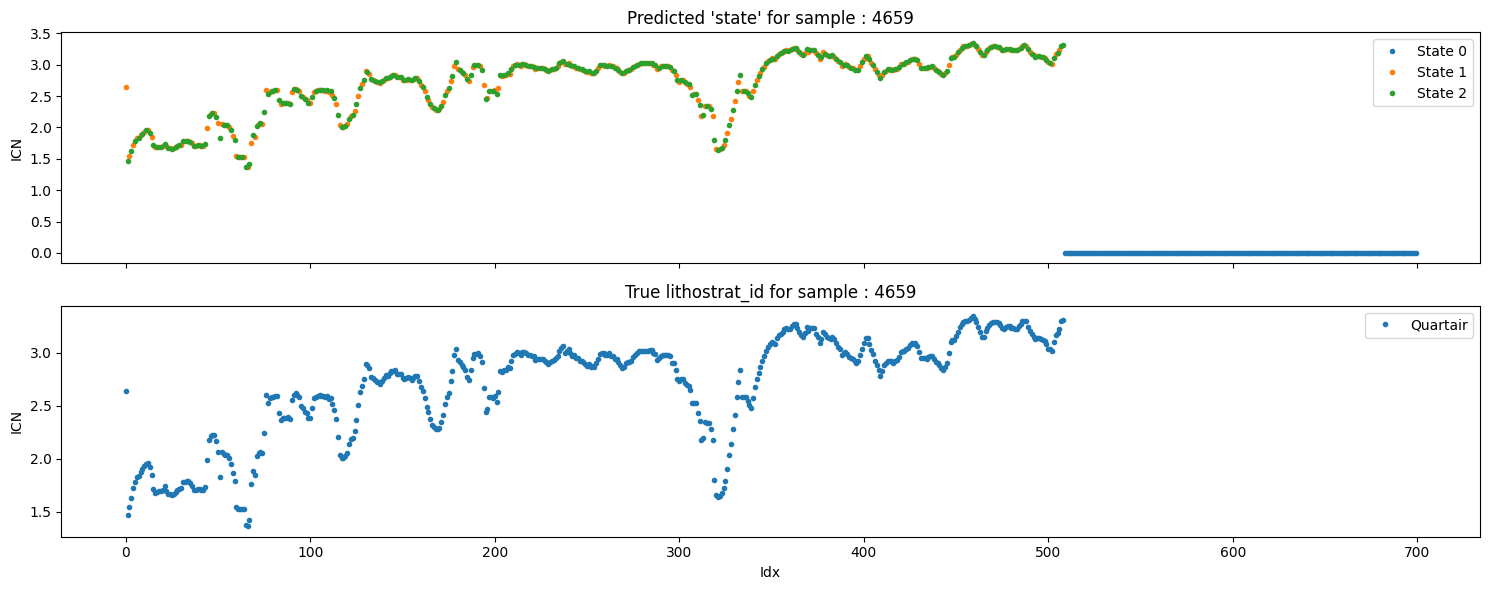

In [26]:

sample_id = hmm_test_set.sondering_id.unique()[0]
subdf = hmm_test_set[hmm_test_set["sondering_id"] == sample_id].copy()
signal = subdf["icn"].values

if len(signal) < 700:
    pad_length = 700 - len(signal)
    signal = np.pad(signal, (0, pad_length), mode='constant', constant_values=0)

signal_reshaped = signal.reshape(-1, 1)
hidden_states = hmm_model.predict(signal_reshaped, [len(signal_reshaped)])


fig, axes = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

for state in np.unique(hidden_states):
    idx = np.where(hidden_states == state)[0]
    axes[0].plot(idx, signal[idx], '.', label=f'State {state}')
axes[0].set_title(f"Predicted 'state' for sample : {sample_id}")
axes[0].set_ylabel("ICN")
axes[0].legend()

true_states = subdf["lithostrat_id"]
for state in np.unique(subdf.lithostrat_id):
    idx = np.where(true_states == state)[0]
    axes[1].plot(idx, signal[idx], '.', label=f'{state}')
axes[1].set_title(f"True lithostrat_id for sample : {sample_id}")
axes[1].set_xlabel("Idx")
axes[1].set_ylabel("ICN")
axes[1].legend()

plt.tight_layout()
plt.show()

## PCA and LDA related stuff

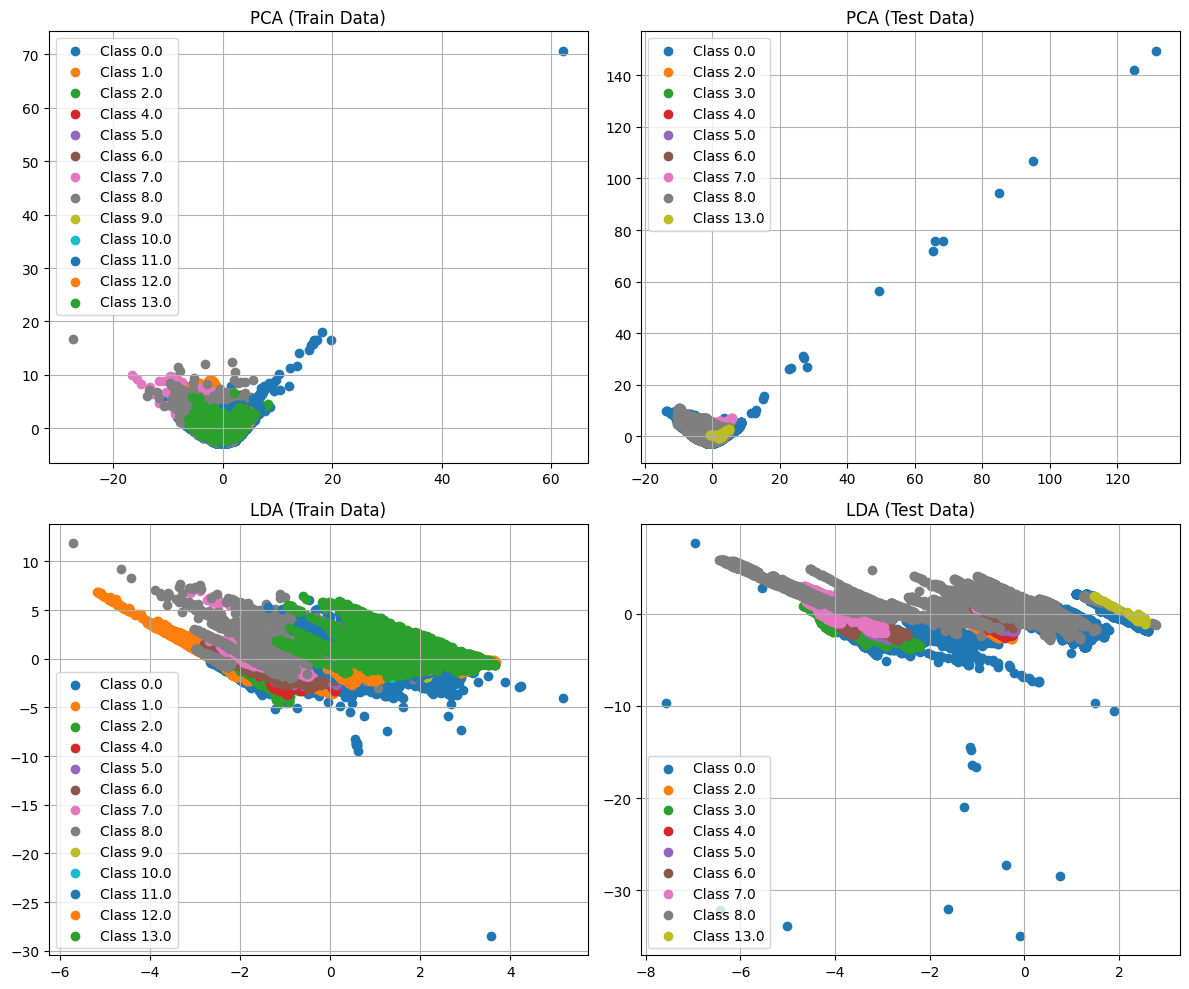

In [27]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lda = LDA()
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

def plot_projection(X_proj, y, title, ax):
    for label in np.unique(y):
        ax.scatter(
            X_proj[y == label, 0],
            X_proj[y == label, 1],
            label=f"Class {label}",
        )
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_projection(X_train_pca, y_train, "PCA (Train Data)", axes[0, 0])
plot_projection(X_test_pca, y_test, "PCA (Test Data)", axes[0, 1])
plot_projection(X_train_lda, y_train, "LDA (Train Data)", axes[1, 0])
plot_projection(X_test_lda, y_test, "LDA (Test Data)", axes[1, 1])

plt.tight_layout()
plt.show()

In [28]:
#This cell runs for approximately 4:30 minutes
# when using just the desired segments, the quality of the separation decreases 
# compared to what I had with the layers I selected

#important
print(pca.explained_variance_ratio_)
print("Cumulative variance:", pca.explained_variance_ratio_.sum())

#not important
X_train_proj = pca.transform(X_train_std)
X_train_recon = pca.inverse_transform(X_train_proj)
pca_recon_error = np.mean((X_train_std - X_train_recon) ** 2)
print("PCA reconstruction MSE (train):", pca_recon_error)

#not important 
silhouette_train_pca = silhouette_score(X_train_proj, y_train)
print("PCA silhouette score (train):", silhouette_train_pca)

##important
X_test_proj = pca.transform(X_test_std)
silhouette_test_pca = silhouette_score(X_test_proj, y_test)
print("PCA silhouette score (test):", silhouette_test_pca)

#important
print("LDA explained variance ratio:", lda.explained_variance_ratio_)

#important
scores_lda = cross_val_score(lda, X_train_std, y_train, cv=5)
print("LDA cross-validated accuracy (train folds):", scores_lda.mean())

#important
X_train_lda_proj = lda.transform(X_train_std)
silhouette_train_lda = silhouette_score(X_train_lda_proj, y_train)
print("LDA silhouette score (train):", silhouette_train_lda)

#not sure
test_accuracy = lda.score(X_test_std, y_test)
print("LDA test set accuracy:", test_accuracy)

#important
X_test_lda_proj = lda.transform(X_test_std)
silhouette_test_lda = silhouette_score(X_test_lda_proj, y_test)
print("LDA silhouette score (test):", silhouette_test_lda)

[4.59281097e-01 2.24541383e-01 1.14159750e-01 1.04910522e-01
 4.50139764e-02 3.34376343e-02 1.32012108e-02 5.18506439e-03
 2.69361991e-04]
Cumulative variance: 1.0
PCA reconstruction MSE (train): 6.068885679113059e-31
PCA silhouette score (train): -0.10467497908152965
PCA silhouette score (test): -0.04508969034666376
LDA explained variance ratio: [4.54170638e-01 2.44922832e-01 1.87324791e-01 6.07712648e-02
 2.81492092e-02 1.88772522e-02 5.21893318e-03 5.48188739e-04
 1.68910564e-05]
LDA cross-validated accuracy (train folds): 0.5560046125967821
LDA silhouette score (train): -0.07310144736936808
LDA test set accuracy: 0.19052811964480448
LDA silhouette score (test): -0.07239227627878742


In [29]:
X_train.columns

Index(['diepte_mtaw', 'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt'], dtype='object')

## Feature engineering related section, 
 some duplicate imports at the start,
 I tried using the seglearn library but it seemed kind of bad in terms of performance,
 but I don't particularly know how to use it


In [30]:
#feature engineering: sliding windows and temporal aggregations
%pip install -U seglearn
#data = load_watch()

features = ['diepte_mtaw','qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt']

# Construct Xt separately for train and test
def Xt_transform(df, cols):
    """Returns time series features for the seglern library"""
    Xt = df[cols].values.astype(np.float32)
    return Xt

Xt_train = Xt_transform(X_train, features)

Xt_test = Xt_transform(X_test, features)


pipe = Pype([('segment', SegmentX(width=5, overlap=0.1)),
    ('features', FeatureRep()),
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())])

pipe.fit([Xt_train], [y_train.values])
score = pipe.score([Xt_test], [y_test.values])
print(score)


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\seglearn\feature_functions.py:185: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.skew(X, axis=1)
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\seglearn\feature_functions.py:190: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.kurtosis(X, axis=1)


Note: you may need to restart the kernel to use updated packages.


c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\seglearn\feature_functions.py:185: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.skew(X, axis=1)
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\seglearn\feature_functions.py:190: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.kurtosis(X, axis=1)
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\seglearn\feature_functions.py:185: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be u

0.31970086468801123


In [31]:

y_pred = pipe.predict([Xt_test])
print(y_pred)

width = pipe.named_steps['segment'].width
overlap = pipe.named_steps['segment'].overlap
stride = int(width * (1 - overlap))

y_true_segments = [
    y_test.values[i + width - 1] 
    for i in range(0, len(y_test) - width + 1, stride)
]

y_true = y_test.values
print(y_true)
print(len(y_pred), len(y_true_segments))
print(set(y_pred), set(y_true_segments))
all_labels = np.unique(np.concatenate([y_true_segments, y_pred]))

report = classification_report(
    y_true_segments,
    y_pred,
    labels=all_labels,           # ensures all labels are included
    target_names=[str(c) for c in all_labels]
)
print(report)

c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\seglearn\feature_functions.py:185: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.skew(X, axis=1)
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\seglearn\feature_functions.py:190: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.kurtosis(X, axis=1)


[0. 0. 0. ... 0. 0. 1.]
[0. 0. 0. ... 8. 8. 8.]
12837 12837
{0.0, 1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0} {0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 13.0}
              precision    recall  f1-score   support

         0.0       0.56      0.85      0.68      3113
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00       231
         3.0       0.00      0.00      0.00      1996
         4.0       0.52      0.71      0.60       245
         5.0       0.39      0.84      0.53       383
         6.0       0.59      0.14      0.22      1306
         7.0       0.17      0.14      0.15      1797
         8.0       0.56      0.14      0.23      3754
         9.0       0.00      0.00      0.00         0
        10.0       0.00      0.00      0.00         0
        11.0       0.00      0.00      0.00         0
        12.0       0.00      0.00      0.00         0
        13.0       0.17      0.17      0.17        12

    accurac

c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

In [32]:
print(score)

0.31970086468801123


In [33]:
def sliding_window(X, id_column, points=5, features=[], new_cols= ["mean", "slope"]):
    processed_subframes = []
    ids_to_process = X[id_column].unique()
    #features = [c for c in X.columns if c != id_column]

    for id in ids_to_process:
        subdf = X[X[id_column] == id].copy()
        n_rows = len(subdf)
        features_list = []
        
        for start in range(0, n_rows - points + 1):
            window = subdf.iloc[start:start + points]
            feats = window.iloc[-1].to_dict()
            feats[id_column] = id
            
            for col in features:
                col_vals = window[col].values
                feats[f"{col}_mean"] = col_vals.mean()
                feats[f"{col}_slope"] = np.polyfit(np.arange(points), col_vals, 1)[0]
            
            features_list.append(feats)
        
        processed_subframes.append(pd.DataFrame(features_list))
    
    return pd.concat(processed_subframes, ignore_index=True)



train = sliding_window(train, 'sondering_id', features = ['qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt'])
train.head()

,sondering_id,index,pkey_sondering,sondeernummer,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,...,rf_mean,rf_slope,fr_mean,fr_slope,icn_mean,icn_slope,sbt_mean,sbt_slope,ksbt_mean,ksbt_slope
0,314,2597,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.0,13.26,...,2.828034,0.017383,2.929968,0.039968,2.576925,0.032710,4.6,-2.000000e-01,2.328600e-07,-2.740000e-09
1,314,2598,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.1,13.16,...,2.701172,-0.027770,2.801396,-0.024404,2.564662,0.014153,4.6,-2.522391e-16,2.482200e-07,-3.211000e-08
2,314,2599,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.2,13.06,...,2.479885,-0.548687,2.575949,-0.581064,2.517331,-0.112146,4.6,2.000000e-01,6.147200e-07,4.263300e-07
3,314,2600,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.3,12.96,...,2.231105,-0.778668,2.321373,-0.839001,2.467513,-0.175019,4.6,4.000000e-01,8.403800e-07,4.642300e-07
4,314,2601,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.4,12.86,...,1.594915,-0.130411,1.629070,-0.136408,2.332234,-0.052963,5.0,-6.490521e-16,1.014000e-06,2.215100e-07


In [34]:
train.columns

Index(['sondering_id', 'index', 'pkey_sondering', 'sondeernummer', 'x', 'y',
       'start_sondering_mtaw', 'diepte_sondering_tot', 'diepte', 'diepte_mtaw',
       'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt', 'lithostrat_id',
       'lithostrat_int', 'qc_mean', 'qc_slope', 'fs_mean', 'fs_slope',
       'qtn_mean', 'qtn_slope', 'rf_mean', 'rf_slope', 'fr_mean', 'fr_slope',
       'icn_mean', 'icn_slope', 'sbt_mean', 'sbt_slope', 'ksbt_mean',
       'ksbt_slope'],
      dtype='object')

In [35]:


X = train[['sondering_id', 'diepte_mtaw', 
       'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt',
       'qc_mean', 'qc_slope', 'fs_mean', 'fs_slope',
       'qtn_mean', 'qtn_slope', 'rf_mean', 'rf_slope', 'fr_mean', 'fr_slope',
       'icn_mean', 'icn_slope', 'sbt_mean', 'sbt_slope', 'ksbt_mean',
       'ksbt_slope']]

y = train[['sondering_id', 'lithostrat_id', 'lithostrat_int']]

In [50]:

drillings = X.sondering_id.unique()
random.Random(seed).shuffle(drillings)
print(len(drillings) * (3/4))

drillings = drillings[0:117]


features = ['diepte_mtaw', 'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt',
       'ksbt', 'qc_mean', 'qc_slope', 'fs_mean', 'fs_slope', 'qtn_mean',
       'qtn_slope', 'rf_mean', 'rf_slope', 'fr_mean', 'fr_slope', 'icn_mean',
       'icn_slope', 'sbt_mean', 'sbt_slope', 'ksbt_mean', 'ksbt_slope']

X_train, y_train, X_test, y_test = X[X.sondering_id.isin(drillings)], y[y.sondering_id.isin(drillings)],X[~X.sondering_id.isin(drillings)], y[~y.sondering_id.isin(drillings)], 
X_test.shape

119.25


(28616, 26)

In [ ]:
#rf w same set: 67%

#5 nn 63%, 1nn 62%

ss = StandardScaler()
model0 = KNeighborsClassifier(n_neighbors = 5)
pipe_zero = Pipeline([("scale",ss),
                     ("knn", model0)])
pipe_zero.fit(X_train[features], y_train["lithostrat_id"])

,steps,"[('scale', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30


In [56]:
y_pred = pipe_zero.predict(X_test[features])
accuracy = accuracy_score(y_test["lithostrat_id"], y_pred)
print("Overall accuracy:", accuracy)

classes = y_test["lithostrat_id"].unique()
matrix = confusion_matrix(y_test["lithostrat_id"], y_pred, labels=classes)

#This is apparently how you get per calss accuracy: 
# https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
granular_acc  = matrix.diagonal()/matrix.sum(axis=1)

df_summary = pd.DataFrame({
    "class": classes,
    "accuracy": granular_acc
})

print("avg accuracy : ", df_summary.accuracy.mean())
print("Individual accuracies : ")
df_summary

Overall accuracy: 0.6309756779424098
avg accuracy :  0.5642706949780532
Individual accuracies : 


,class,accuracy
0,Quartair,0.827299
1,Mont_Panisel,0.631070
2,Aalbeke,0.411504
3,Brussel,0.516058
4,Ursel,0.452165
5,Asse,0.573209
6,Wemmel,0.639576
7,Lede,0.477060
8,Mons_en_Pevele,0.452180
9,Kwatrecht,0.823090


In [ ]:

#preproc_segs_to_dummies(pd.concat([X_train, y_train], axis=1, ignore_index=True))
#plot_dummy_segpres(preproc_segs_to_dummies(pd.concat([X_train, y_train], axis=1, ignore_index=True)), filename = "temp_trainplot.html")

#plot_dummy_segpres(preproc_segs_to_dummies(pd.concat([X_test, y_test], axis=1, ignore_index=True)), filename = "temp_testplot.html")

In [53]:
model1 = RandomForestClassifier(
    n_estimators=200,
    random_state=seed,
    class_weight='balanced'
)


model1.fit(X_train[features], y_train['lithostrat_id'])

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [54]:
y_pred = model1.predict(X_test[features])
accuracy = accuracy_score(y_test["lithostrat_id"], y_pred)
print("Overall accuracy:", accuracy)

classes = y_test["lithostrat_id"].unique()
matrix = confusion_matrix(y_test["lithostrat_id"], y_pred, labels=classes)

#This is apparently how you get per calss accuracy: 
# https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
granular_acc  = matrix.diagonal()/matrix.sum(axis=1)

df_summary = pd.DataFrame({
    "class": classes,
    "accuracy": granular_acc
})

print("avg accuracy : ", df_summary.accuracy.mean())
print("Individual accuracies : ")
df_summary

Overall accuracy: 0.6783617556611686
avg accuracy :  0.5803929141757256
Individual accuracies : 


,class,accuracy
0,Quartair,0.920618
1,Mont_Panisel,0.669244
2,Aalbeke,0.289086
3,Brussel,0.705426
4,Ursel,0.274924
5,Asse,0.743510
6,Wemmel,0.623675
7,Lede,0.534581
8,Mons_en_Pevele,0.470091
9,Kwatrecht,0.726744


In [ ]:
print(classification_report(y_test["lithostrat_id"], y_pred))

                precision    recall  f1-score   support

       Aalbeke       0.78      0.31      0.45       933
          Asse       0.64      0.45      0.53      1130
    Bolderberg       0.25      0.37      0.30       140
       Brussel       0.67      0.64      0.65      3142
         Diest       0.00      0.00      0.00         0
     Kwatrecht       0.81      0.49      0.61       593
          Lede       0.48      0.64      0.55      2617
     Merelbeke       0.00      0.00      0.00        16
Mons_en_Pevele       0.70      0.24      0.36      2348
  Mont_Panisel       0.50      0.91      0.64      1787
      Quartair       0.83      0.87      0.85      7854
         Ursel       0.85      0.80      0.83      1138
        Wemmel       0.54      0.57      0.55      1367

      accuracy                           0.67     23065
     macro avg       0.54      0.48      0.49     23065
  weighted avg       0.70      0.67      0.66     23065



c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

In [ ]:
# conclusions: here I see that there is a huge difference between whether diepte mtaw or diepte is used as the depth variable. 
# suggest that that is investigated.
# a quick explanation is obtained with:
from scipy.stats import pearsonr

pearsonr(df["x"]*df["y"], df["diepte_mtaw"])

# which shows that the location of the drilling is strongly correlated with the diepte mtaw. 
# It seems that a much better classifier is obtained if location is incorporated, in all cases

PearsonRResult(statistic=-0.38409500223883125, pvalue=0.0)

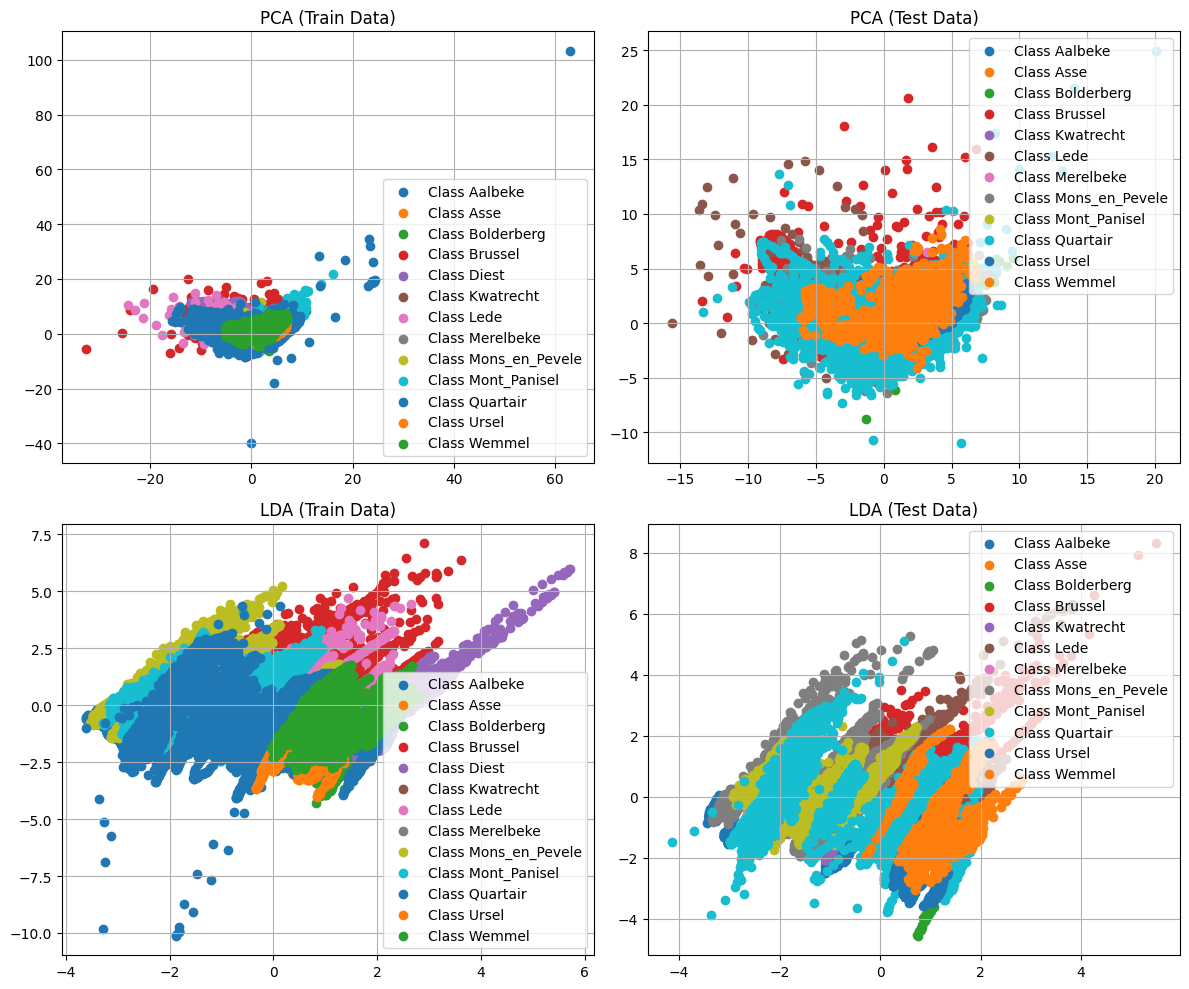

In [ ]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train[features])
X_test_std = scaler.transform(X_test[features])

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lda = LDA()
X_train_lda = lda.fit_transform(X_train_std, y_train["lithostrat_id"])
X_test_lda = lda.transform(X_test_std)

def plot_projection(X_proj, y, title, ax):
    for label in np.unique(y):
        ax.scatter(
            X_proj[y == label, 0],
            X_proj[y == label, 1],
            label=f"Class {label}",
        )
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_projection(X_train_pca, y_train["lithostrat_id"], "PCA (Train Data)", axes[0, 0])
plot_projection(X_test_pca, y_test["lithostrat_id"], "PCA (Test Data)", axes[0, 1])
plot_projection(X_train_lda, y_train["lithostrat_id"], "LDA (Train Data)", axes[1, 0])
plot_projection(X_test_lda, y_test["lithostrat_id"], "LDA (Test Data)", axes[1, 1])

plt.tight_layout()
plt.show()

In [ ]:
#This cell runs for approximately 4:30 minutes

#important
print(pca.explained_variance_ratio_)
print("Cumulative variance:", pca.explained_variance_ratio_.sum())

#not important
X_train_proj = pca.transform(X_train_std)
X_train_recon = pca.inverse_transform(X_train_proj)
pca_recon_error = np.mean((X_train_std - X_train_recon) ** 2)
print("PCA reconstruction MSE (train):", pca_recon_error)

#not important 
silhouette_train_pca = silhouette_score(X_train_proj, y_train["lithostrat_id"])
print("PCA silhouette score (train):", silhouette_train_pca)

##important
X_test_proj = pca.transform(X_test_std)
silhouette_test_pca = silhouette_score(X_test_proj, y_test["lithostrat_id"])
print("PCA silhouette score (test):", silhouette_test_pca)

#important
print("LDA explained variance ratio:", lda.explained_variance_ratio_)

#important
scores_lda = cross_val_score(lda, X_train_std, y_train["lithostrat_id"], cv=5)
print("LDA cross-validated accuracy (train folds):", scores_lda.mean())

#important
X_train_lda_proj = lda.transform(X_train_std)
silhouette_train_lda = silhouette_score(X_train_lda_proj, y_train["lithostrat_id"])
print("LDA silhouette score (train):", silhouette_train_lda)

#not sure
test_accuracy = lda.score(X_test_std, y_test["lithostrat_id"])
print("LDA test set accuracy:", test_accuracy)

#important
X_test_lda_proj = lda.transform(X_test_std)
silhouette_test_lda = silhouette_score(X_test_lda_proj, y_test["lithostrat_id"])
print("LDA silhouette score (test):", silhouette_test_lda)

[3.27618472e-01 1.64969848e-01 1.39482165e-01 8.60491674e-02
 6.69711746e-02 4.49223637e-02 4.08220380e-02 2.89858321e-02
 2.82117536e-02 2.11093095e-02 1.78660307e-02 8.10024572e-03
 7.88118774e-03 6.48825142e-03 4.04150245e-03 2.64134469e-03
 2.57263103e-03 5.02414862e-04 2.75053101e-04 1.77489674e-04
 1.22502699e-04 1.16466053e-04 5.37661712e-05 1.54169246e-05
 3.57307309e-06]
Cumulative variance: 0.9999999999999998
PCA reconstruction MSE (train): 1.538478659724043e-30
PCA silhouette score (train): -0.10800348085798207
PCA silhouette score (test): -0.10326796448948644
LDA explained variance ratio: [4.87514896e-01 2.22284530e-01 1.68023181e-01 5.91060557e-02
 3.63526396e-02 1.87548968e-02 6.77004007e-03 1.01782871e-03
 1.07867939e-04 5.56080080e-05 9.66980005e-06 2.78648905e-06]
LDA cross-validated accuracy (train folds): 0.5665599467237962
LDA silhouette score (train): -0.07047302634964552
LDA test set accuracy: 0.5789724691090397
LDA silhouette score (test): -0.06982271578037409


In [ ]:
y_pred = lda.predict(X_test_std)

report = classification_report(
    y_test["lithostrat_id"],
    y_pred,
    labels=y_test["lithostrat_id"].unique(),
    target_names=[str(c) for c in y_test["lithostrat_id"].unique()]
)

print(report)

                precision    recall  f1-score   support

      Quartair       0.79      0.78      0.78      7854
  Mont_Panisel       0.46      0.57      0.51      1787
       Aalbeke       0.52      0.47      0.50       933
Mons_en_Pevele       0.81      0.20      0.32      2348
       Brussel       0.49      0.42      0.45      3142
         Ursel       0.63      0.76      0.69      1138
          Asse       0.53      0.58      0.56      1130
        Wemmel       0.66      0.39      0.49      1367
          Lede       0.49      0.64      0.55      2617
     Merelbeke       0.00      0.00      0.00        16
     Kwatrecht       0.21      0.45      0.29       593
    Bolderberg       0.38      0.17      0.24       140

     micro avg       0.60      0.58      0.59     23065
     macro avg       0.50      0.45      0.45     23065
  weighted avg       0.63      0.58      0.58     23065



In [ ]:
lda = LDA()
lda_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('lda', lda)
])
lda_pipe.fit(X_train[features], y_train["lithostrat_id"])


lda_features = FunctionTransformer(
    func=lambda X: lda_pipe.named_steps['lda'].predict_proba(
        lda_pipe.named_steps['scaler'].transform(X)
    ),
    validate=False
)

stack_pipe = Pipeline([
    ('lda_probs', lda_features),
    ('rf', RandomForestClassifier(n_estimators=200,
    random_state=seed,
    class_weight='balanced'))
])

stack_pipe.fit(X_train[features], y_train["lithostrat_id"])


score = stack_pipe.score(X_test[features], y_test["lithostrat_id"])
print("Stacked pipeline accuracy:", score)

Stacked pipeline accuracy: 0.6500758725341427


In [ ]:
y_pred = stack_pipe.predict(X_test[features])


report = classification_report(y_test["lithostrat_id"], y_pred, target_names=[str(c) for c in np.unique(y_train["lithostrat_id"])])
print(report)

                precision    recall  f1-score   support

       Aalbeke       0.78      0.31      0.44       933
          Asse       0.66      0.38      0.48      1130
    Bolderberg       0.29      0.40      0.33       140
       Brussel       0.73      0.72      0.73      3142
         Diest       0.00      0.00      0.00         0
     Kwatrecht       0.71      0.59      0.64       593
          Lede       0.46      0.64      0.54      2617
     Merelbeke       0.00      0.00      0.00        16
Mons_en_Pevele       0.63      0.22      0.33      2348
  Mont_Panisel       0.52      0.88      0.65      1787
      Quartair       0.79      0.81      0.80      7854
         Ursel       0.80      0.57      0.67      1138
        Wemmel       0.46      0.63      0.53      1367

      accuracy                           0.65     23065
     macro avg       0.52      0.47      0.47     23065
  weighted avg       0.68      0.65      0.64     23065



c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no t

## Spatial cross validation splits

In [141]:
train["spatial_sum"] = train["x"] + train["y"]
train.sort_values(["spatial_sum", "sondering_id", "index"], inplace=True)
print(train[train.spatial_sum.isna()][["x","y"]])
train.head()

Empty DataFrame
Columns: [x, y]
Index: []


,sondering_id,index,pkey_sondering,sondeernummer,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,...,rf_slope,fr_mean,fr_slope,icn_mean,icn_slope,sbt_mean,sbt_slope,ksbt_mean,ksbt_slope,spatial_sum
2077,495,6154,https://www.dov.vlaanderen.be/data/sondering/2...,GEO-02/107-S4,143229.5,171975.9,57.14,15.0,8.75,48.39,...,0.164806,3.346181,0.209536,2.833010,0.040507,4.0,-4.203168e-16,2.524000e-08,-8.580000e-09,315205.4
2078,495,6155,https://www.dov.vlaanderen.be/data/sondering/2...,GEO-02/107-S4,143229.5,171975.9,57.14,15.0,8.80,48.34,...,0.068564,3.574971,0.091587,2.876387,0.016624,4.0,-4.203168e-16,1.648000e-08,-1.910000e-09,315205.4
2079,495,6156,https://www.dov.vlaanderen.be/data/sondering/2...,GEO-02/107-S4,143229.5,171975.9,57.14,15.0,8.85,48.29,...,0.027548,3.638785,0.038720,2.888674,0.007933,4.0,-4.203168e-16,1.498000e-08,-8.500000e-10,315205.4
2080,495,6157,https://www.dov.vlaanderen.be/data/sondering/2...,GEO-02/107-S4,143229.5,171975.9,57.14,15.0,8.90,48.24,...,0.140208,3.755123,0.160215,2.893192,0.011708,4.0,-4.203168e-16,1.454000e-08,-1.280000e-09,315205.4
2081,495,6158,https://www.dov.vlaanderen.be/data/sondering/2...,GEO-02/107-S4,143229.5,171975.9,57.14,15.0,8.95,48.19,...,0.148824,3.915390,0.159227,2.904901,0.003521,4.0,-4.203168e-16,1.326000e-08,-3.300000e-10,315205.4


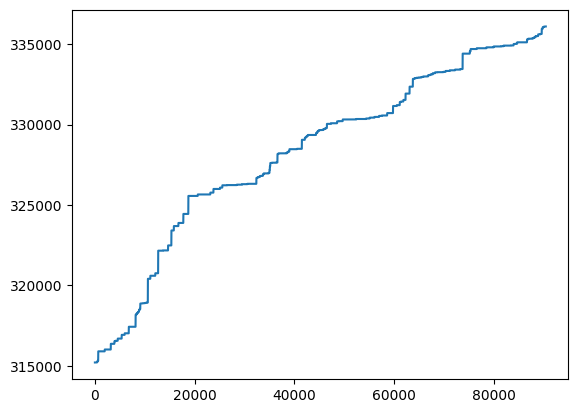

In [143]:
plt.plot(range(train.shape[0]),train["spatial_sum"])

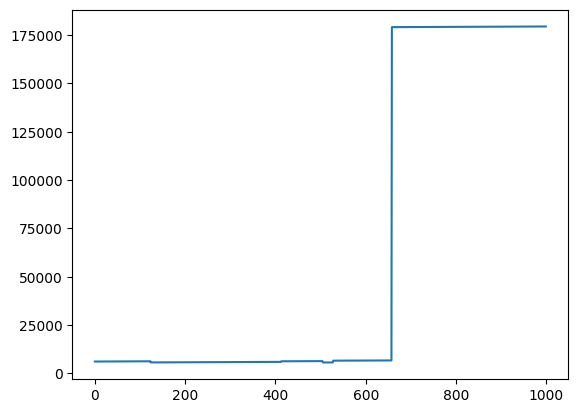

In [144]:
plt.plot(range(train.shape[0])[0:1000],train["index"][0:1000])

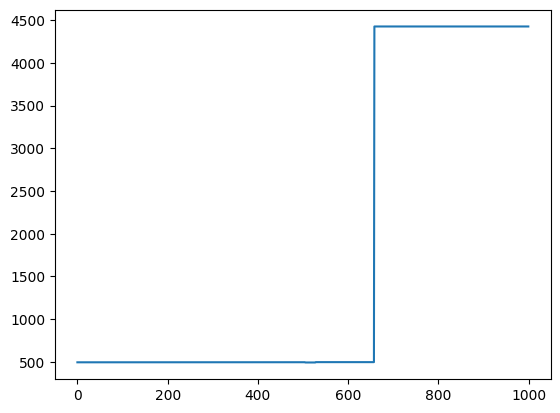

In [145]:
plt.plot(range(train.shape[0])[0:1000],train["sondering_id"][0:1000])

127.2
(24621, 27) (65798, 27)


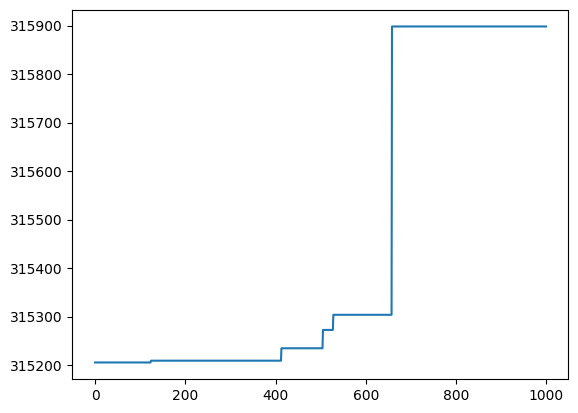

In [146]:
drillings = train.sondering_id.unique()
#random.Random(seed).shuffle(drillings)
print(len(drillings) * (4/5))

drillings = drillings[0:117]


features = ['diepte_mtaw', 'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt',
       'ksbt', 'qc_mean', 'qc_slope', 'fs_mean', 'fs_slope', 'qtn_mean',
       'qtn_slope', 'rf_mean', 'rf_slope', 'fr_mean', 'fr_slope', 'icn_mean',
       'icn_slope', 'sbt_mean', 'sbt_slope', 'ksbt_mean', 'ksbt_slope', "spatial_sum", "sondering_id"]

X_train, y_train, X_test, y_test = train[train.sondering_id.isin(drillings)][features],\
         train[train.sondering_id.isin(drillings)]["lithostrat_id"],\
       train[~train.sondering_id.isin(drillings)][features], \
              train[~train.sondering_id.isin(drillings)]["lithostrat_id"], 
print(X_test.shape,X_train.shape)
plt.plot(range(1000),X_train["spatial_sum"][0:1000])


In [147]:
X_test["spatial_sum"]

29562    332982.58
29563    332982.58
29564    332982.58
29565    332982.58
29566    332982.58
           ...    
5515     336102.40
5516     336102.40
5517     336102.40
5518     336102.40
5519     336102.40
Name: spatial_sum, Length: 24621, dtype: float64

In [162]:
from sklearn.model_selection import GroupKFold
groups = X_train["sondering_id"]


splitter = GroupKFold(n_splits=10)
X_train_c = X_train.copy()

splits = splitter.split(X_train_c, y_train, groups)

ss = StandardScaler()
model0 = KNeighborsClassifier()
pipe_zero = Pipeline([("scale",ss),
                     ("knn", model0)])


for fold, indexes in splits:
    print(fold, indexes)

cv_scores = cross_val_score(pipe_zero, X_train_c, y_train, groups=groups, cv=splitter)

[    0     1     2 ... 65795 65796 65797] [ 8313  8314  8315 ... 48929 48930 48931]
[    0     1     2 ... 65795 65796 65797] [ 3898  3899  3900 ... 60520 60521 60522]
[    0     1     2 ... 65795 65796 65797] [ 8634  8635  8636 ... 64893 64894 64895]
[    0     1     2 ... 65795 65796 65797] [ 3177  3178  3179 ... 64484 64485 64486]
[  413   414   415 ... 65795 65796 65797] [    0     1     2 ... 65305 65306 65307]
[    0     1     2 ... 65795 65796 65797] [  528   529   530 ... 63087 63088 63089]
[    0     1     2 ... 65795 65796 65797] [ 8472  8473  8474 ... 61365 61366 61367]
[    0     1     2 ... 65552 65553 65554] [ 4568  4569  4570 ... 65795 65796 65797]
[    0     1     2 ... 65795 65796 65797] [  413   414   415 ... 64106 64107 64108]
[    0     1     2 ... 65795 65796 65797] [  505   506   507 ... 65552 65553 65554]


In [163]:
print("Mean accuracy across folds : ", np.mean(cv_scores))
print("Accuracy for each fold : ", cv_scores) # -> highly variable across new regions!

Mean accuracy across folds :  0.6690931742748358
Accuracy for each fold :  [0.68192881 0.69067603 0.75658492 0.7249924  0.64788732 0.68941462
 0.73392965 0.54927647 0.60618054 0.61006098]


In [113]:
print(X_train.columns)
print(X_test.columns)

Index(['diepte_mtaw', 'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt',
       'qc_mean', 'qc_slope', 'fs_mean', 'fs_slope', 'qtn_mean', 'qtn_slope',
       'rf_mean', 'rf_slope', 'fr_mean', 'fr_slope', 'icn_mean', 'icn_slope',
       'sbt_mean', 'sbt_slope', 'ksbt_mean', 'ksbt_slope', 'spatial_sum',
       'sondering_id'],
      dtype='object')
Index(['diepte_mtaw', 'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt',
       'qc_mean', 'qc_slope', 'fs_mean', 'fs_slope', 'qtn_mean', 'qtn_slope',
       'rf_mean', 'rf_slope', 'fr_mean', 'fr_slope', 'icn_mean', 'icn_slope',
       'sbt_mean', 'sbt_slope', 'ksbt_mean', 'ksbt_slope', 'spatial_sum',
       'sondering_id'],
      dtype='object')


In [149]:
X_test_c = X_test.copy()
X_test_c.drop(["sondering_id", "spatial_sum"], axis=1, inplace=True)

In [150]:
score = pipe_zero.score(X_test_c, y_test)
print("Stacked pipeline accuracy:", score)

Stacked pipeline accuracy: 0.8785589537386783


In [151]:
y_pred = pipe_zero.predict(X_test_c)
accuracy = accuracy_score(y_test, y_pred)
print("Overall accuracy:", accuracy)

classes = y_test.unique()
matrix = confusion_matrix(y_test, y_pred, labels=classes)

#This is apparently how you get per calss accuracy: 
# https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
granular_acc  = matrix.diagonal()/matrix.sum(axis=1)

df_summary = pd.DataFrame({
    "class": classes,
    "accuracy": granular_acc
})

print("avg accuracy : ", df_summary.accuracy.mean())
print("Individual accuracies : ")
df_summary

Overall accuracy: 0.8785589537386783
avg accuracy :  0.7892499309875781
Individual accuracies : 


,class,accuracy
0,Quartair,0.942140
1,Mons_en_Pevele,0.691280
2,Aalbeke,0.872466
3,Mont_Panisel,0.831378
4,Brussel,0.882759
5,Diest,0.950703
6,Kwatrecht,0.801170
7,Merelbeke,0.342105


In [152]:
print(y_train)

2077            Aalbeke
2078            Aalbeke
2079            Aalbeke
2080            Aalbeke
2081            Aalbeke
              ...      
29557    Mons_en_Pevele
29558    Mons_en_Pevele
29559    Mons_en_Pevele
29560    Mons_en_Pevele
29561    Mons_en_Pevele
Name: lithostrat_id, Length: 65798, dtype: object


In [ ]:
X_test_p = X_test.copy()
X_test_p["lithostrat_id"] = y_test



In [159]:
plot_dummy_segpres(preproc_segs_to_dummies(train[train.sondering_id.isin(drillings)]), filename = "temp_trainplot.html")

plot_dummy_segpres(preproc_segs_to_dummies(train[~train.sondering_id.isin(drillings)]), filename = "temp_testplot.html")

In [171]:
groups = X_train["sondering_id"]


splitter = GroupKFold(n_splits=10)

X_train_c.drop(["sondering_id", "spatial_sum"], axis=1, inplace=True)

splits = splitter.split(X_train_c, y_train, groups)



spat_rf = RandomForestClassifier(
    n_estimators=200,
    random_state=seed,
    class_weight='balanced'
)


for fold, indexes in splits:
    print(fold, indexes)

cv_scores = cross_val_score(spat_rf, X_train_c, y_train, groups=groups, cv=splitter)



KeyError: "['sondering_id', 'spatial_sum'] not found in axis"

In [169]:

spat_rf.fit(X_train_c, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("CV scores : ", cv_scores)
print("Mean score across CVs : ", np.mean(cv_scores))
score = spat_rf.score(X_test_c, y_test)
print("Accuracy on test:", score)


print("Mean accuracy across folds : ", np.mean(cv_scores))
print("Accuracy for each fold : ", cv_scores) 


y_pred = spat_rf.predict(X_test_c)
accuracy = accuracy_score(y_test, y_pred)
print("Overall accuracy:", accuracy)

classes = y_test.unique()
matrix = confusion_matrix(y_test, y_pred, labels=classes)

#This is apparently how you get per calss accuracy: 
# https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
granular_acc  = matrix.diagonal()/matrix.sum(axis=1)

df_summary = pd.DataFrame({
    "class": classes,
    "accuracy": granular_acc
})

print("avg accuracy : ", df_summary.accuracy.mean())
print("Individual accuracies : ")
df_summary

CV scores :  [0.73745056 0.64504807 0.71041477 0.74749164 0.71497804 0.77934486
 0.77653123 0.67418126 0.6422591  0.53643293]
Mean score across CVs :  0.6964132462812005
Stacked pipeline accuracy: 0.4335729661670931
Mean accuracy across folds :  0.6964132462812005
Accuracy for each fold :  [0.73745056 0.64504807 0.71041477 0.74749164 0.71497804 0.77934486
 0.77653123 0.67418126 0.6422591  0.53643293]
Overall accuracy: 0.4335729661670931
avg accuracy :  0.2794794655251659
Individual accuracies : 


,class,accuracy
0,Quartair,0.949123
1,Mons_en_Pevele,0.765324
2,Aalbeke,0.000000
3,Mont_Panisel,0.342105
4,Brussel,0.176359
5,Diest,0.000000
6,Kwatrecht,0.002924
7,Merelbeke,0.000000


In [172]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential([
        Masking(mask_value=0.0, input_shape=input_shape),
        LSTM(hidden_units),
        Dense(1, activation='softmax')])